In [29]:
from numba import jit
import numpy as np
from numba import jit, int32, float32, types, typed
from numba.typed import List
from numba.experimental import jitclass
import matplotlib.pyplot as plt

In [49]:
gyro_radius = 3.086*10**16*10**-4 #10^-4pc
steps_per_gyration = 1/0.05
c = 3*10**8

In [57]:
@jit(nopython=True, fastmath=True)
def propagate(particle_id, spheres):
    pos = [0.0, 0.0, 0.0]
    phi = 0.0
    particle_info = []
    direction = [1,1,1]
    isotrop = False
    
    for i in range(1,10**5): 
        pos_prev = pos
        
        ### change direction ############################################################
        if np.random.random() < 0.001:
            direction[0] = -1*direction[0]
        if np.random.random() < 0.001:
            direction[1] = -1*direction[1]
        if np.random.random() < 0.001:
            direction[2] = -1*direction[2]
            
        ### move in updated direction ###########################################################
        if isotrop:
            normalize = (direction[0]**2+direction[1]**2+direction[2]**2)**0.5
            for j in range(3):
                pos[j] = pos[j] + direction[j]/normalize
        else:
            phi_old = phi
            phi = phi_old + 2 * np.pi / steps_per_gyration
            ### move in phi direction
            delta_x = gyro_radius * (np.cos(phi) - np.cos(phi_old)) * direction[0]
            delta_y = gyro_radius * (np.sin(phi) - np.sin(phi_old)) * direction[0]
            ### move in rho direction
            delta_x = delta_x + np.cos(phi) * gyro_radius * direction[1]
            delta_y = delta_y + np.sin(phi) * gyro_radius * direction[1]
            normalize = ((delta_x**2 + delta_y**2) * 3)**0.5
            pos[0] = pos[0] + delta_x / normalize * c * steps_per_gyration 
            pos[1] = pos[1] + delta_y / normalize * c * steps_per_gyration 
            pos[2] = pos[2] + direction[2] / 3**0.5 * c * steps_per_gyration 

        
        ### observer ####################################################################
        r2_prev = pos_prev[0]**2+pos_prev[1]**2+pos_prev[2]**2
        r2 = pos[0]**2+pos[1]**2+pos[2]**2
        if i<1000 or i%500 == 0:
            particle_info.append([particle_id, i, pos[0], pos[1], pos[2], -1.0])
        for r2_sphere in spheres:
            if r2_prev > r2_sphere and r2 <= r2_sphere or r2_prev < r2_sphere and r2 >= r2_sphere:
                particle_info.append([particle_id, i, pos[0], pos[1], pos[2], r2_sphere*1.0])
        
    return particle_info

In [58]:
@jit(nopython=True)
def many_particles(observer_spheres):
    data = [[0.0, 0.0, 0.0, 0.0, -1.0]]
    for i in range(10**2):
        particle_id = i
        data_new = propagate(particle_id, observer_spheres)
        data = data + data_new

    print('finished')
    return data

In [59]:
observer_spheres = np.array([-1.0]) 
%time data = many_particles(observer_spheres)

finished
Wall time: 2.11 s


In [60]:
import pandas as pd
df = pd.DataFrame(data[1:])
df.columns = ['id', 't', 'x', 'y', 'z', 'radius']
df

,id,t,x,y,z,radius
0,0.0,1.0,2.857768e+09,1.957846e+09,3.464102e+09,-1.0
1,0.0,2.0,4.970660e+09,4.702966e+09,6.928203e+09,-1.0
2,0.0,3.0,6.131851e+09,7.966651e+09,1.039230e+10,-1.0
3,0.0,4.0,6.227674e+09,1.142943e+10,1.385641e+10,-1.0
4,0.0,5.0,5.248752e+09,1.475233e+10,1.732051e+10,-1.0
...,...,...,...,...,...,...
119695,99.0,97500.0,1.843892e+11,2.778764e+10,-2.106867e+13,-1.0
119696,99.0,98000.0,1.843892e+11,2.778764e+10,-2.280072e+13,-1.0
119697,99.0,98500.0,1.833204e+11,3.529823e+10,-2.453277e+13,-1.0
119698,99.0,99000.0,1.833204e+11,3.529823e+10,-2.626482e+13,-1.0


In [61]:
# remove duplicated elements from list of times 
times = []
[times.append(t) for t in df['t'] if t not in times]
kappa_perp = []
kappa_para = []
for t in times:
    df_t = df.loc[df['t'] ==  t]
    kappa_perp.append(np.mean((df_t['x'].values**2+df_t['y'].values**2))/(2*t))
    kappa_para.append(np.mean(df_t['z'].values**2)/(2*t))

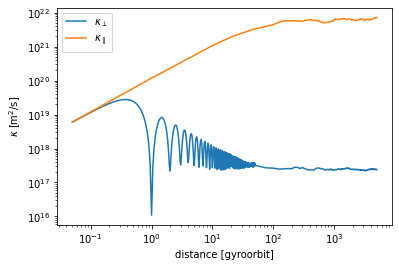

In [62]:
from modules.Plotter import Plotter
import matplotlib.pyplot as plt
### each step is one second -> times = steps
plt.plot(np.array(times) / steps_per_gyration, kappa_perp, label='$\kappa_\perp$')
plt.plot(np.array(times) / steps_per_gyration, kappa_para, label='$\kappa_\parallel$')
plt.xlabel('distance [gyroorbit]')
plt.ylabel('$\kappa$ [m$^2$/s]')
plt.legend()
plt.loglog()
plt.show()

In [63]:
print(np.log10(np.mean(kappa_para[-10:]))-np.log10(np.mean(kappa_perp[-10:])))

4.471911465420579


### Lessons learned

The parameter steps_per_gyration moves the first minimum linearly, which is expected -> increasing by 10 moves minima by factor 10 to right